In [ ]:
!pip3 install mushroom_rl
from IPython.display import clear_output
# clear_output()

# 1.1 The Stairway to Heaven Environment


In [ ]:
from mushroom_rl.environments import FiniteMDP
from mushroom_rl.utils.viewer import Viewer

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
import cv2
import pygame
pygame.init()
screen = pygame.display.set_mode((500, 500))

class StairwayToHeaven(FiniteMDP):
    """
    The Stairway to Heaven environment.
    It is a mini grid environment with lava in the center column that divides the grid in two parts.
    The agent is spawn in the first part and the goal (the heaven) is in the second part.
    There is a button in top-left corner that builds a stairway over the lava
    The stairway can collapse with a probability of 0.03 at each step.
    The agent can move in the four directions.
    The episode ends when the agent reaches the goal
    """
    def __init__(self, gamma=0.99, horizon=100, action_success_prob=0.95, collapse_prob=0.03):

        # The grid
        # S is a potential start position
        # B is the button
        # G is the goal
        # # is lava

        # the stairway is not built
        grid_map1=np.array(
           [['B', 'S', 'S', 'S', 'S', '#', '.', '.', '.', '.', '.'],
            ['S', 'S', 'S', 'S', 'S', '#', '.', '.', '.', '.', '.'],
            ['S', 'S', 'S', 'S', 'S', '#', '.', '.', '.', '.', '.'],
            ['S', 'S', 'S', 'S', 'S', '#', '.', '.', '.', '.', '.'],
            ['S', 'S', 'S', 'S', 'S', '#', '.', '.', '.', '.', '.'],
            ['S', 'S', 'S', 'S', 'S', '#', '.', '.', '.', '.', '.'],
            ['S', 'S', 'S', 'S', 'S', '#', '.', '.', '.', '.', '.'],
            ['S', 'S', 'S', 'S', 'S', '#', '.', '.', '.', '.', '.'],
            ['S', 'S', 'S', 'S', 'S', '#', '.', '.', '.', '.', '.'],
            ['S', 'S', 'S', 'S', 'S', '#', '.', '.', '.', '.', '.'],
            ['S', 'S', 'S', 'S', 'S', '#', '.', '.', '.', '.', 'G']
            ]
        )
        H,W = grid_map1.shape
        # the stairway is built
        grid_map2=grid_map1.copy()
        grid_map2[0][0]='.'
        grid_map2[np.where(grid_map2=='S')]='.'
        grid_map2[H//2][W//2]='.'
        # append grids for the two cases of the stairway
        grid_map = np.array([grid_map1, grid_map2])
        self.grid_map = grid_map

        # change in coordinates for each action
        # Right, Down, Left, Up
        self.directions = [[0, 1], [1, 0], [0, -1], [-1, 0]]

        # get a cell list with all valid states
        cell_list = self.parse_grid(grid_map)
        self.cell_list = cell_list

        # compute transition probability and reward matrix
        p = self.compute_probabilities(grid_map, cell_list, action_success_prob, collapse_prob)
        r = self.compute_reward(grid_map, cell_list)
        # initial state distribution
        mu=self.compute_mu(grid_map, cell_list)

        # call constructor of parent class FiniteMDP
        super().__init__(p, r, mu, gamma, horizon)

        # define a viewer for visualization
        self._viewer = Viewer(W+1, H+1, 500, 500)

        # reset the environment
        self.reset()

    def parse_grid(self, grid):
        """
        Parse the grid to get a cell list with all
        valid states in the environment

        Args:
            grid_map (list): list containing the grid structure;

        Returns:
            cell_list (list): list of non-wall cells

        """
        H,W = grid[0].shape
        cell_list = list()

        # parse first layer of grid
        for i in range(H):
          for j in range(W):
            if grid[0][i][j] in ['.', 'G', 'S']:  # does not include button state and lava!
              cell_list.append([0, i, j])

        # parse second layer of grid
        for i in range(H):
          for j in range(W):
            if grid[1][i][j] in ['.', 'G']:
              cell_list.append([1, i, j])

        return cell_list


    def compute_probabilities(self, grid_map, cell_list, action_success_prob, collapse_prob):
        """
        Compute the transition probability matrix.

        Args:
            grid_map (list): list containing the grid structure;
            cell_list (list): list of non-wall cells;
            prob (float): probability of success of an action.

        Returns:
            The transition probability matrix;

        """
        g = np.array(grid_map)
        c = np.array(cell_list)
        n_states = len(cell_list)
        n_actions = len(self.directions)
        # initialize transition probability matrix
        p = np.zeros((n_states, n_actions, n_states))

        # iterate over all states in the cell list
        for i in range(len(c)):
          state = c[i]
          if g[tuple(state)] in ['.', 'S']:
            for a in range(n_actions):
              new_state = state.copy()
              new_state[1:] += self.directions[a]

              # if agent hits the button, agent transfers into second layer of grid (with build the stairway)
              if (new_state==[0,0,0]).all():
                new_state[0]=1

              # check if new state is a valid state (state in cell list)
              j = np.where((c == new_state).all(axis=1))[0]
              if j.size > 0:
                assert j.size == 1   # valid state
                p[i, a, i] = 1. - action_success_prob    # action failure
                p[i, a, j] = action_success_prob         # action success
              else:
                p[i, a, i] = 1

              # The stairway can collapse
              # The collapse event and the actions are independent events
              if state[0] == 1:
                # check if current and new state exist in grid without stairway
                i_c = np.where((c == [0, state[1], state[2]]).all(axis=1))[0]
                j_c = np.where((c == [0, new_state[1], new_state[2]]).all(axis=1))[0]
                # agent stays at current position and stairway collapses
                if i_c.size > 0:
                  p[i, a, i_c] = p[i, a, i] * collapse_prob
                  p[i, a, i] *= (1 - collapse_prob)
                # agent changes position and stairway collapses
                if j_c.size > 0:
                  p[i, a, j_c] = p[i, a, j] * collapse_prob
                  p[i, a, j] *= (1 - collapse_prob)
        return p

    def compute_reward(self, grid_map, cell_list):
        """
        Compute the reward matrix.

        Args:
            grid_map (list): list containing the grid structure;
            cell_list (list): list of non-wall cells;

        Returns:
            The reward matrix.

        """
        g = np.array(grid_map)
        c = np.array(cell_list)
        n_states = len(c)
        n_actions = len(self.directions)
        # initialize reward matrix
        r = np.ones((n_states, n_actions, n_states)) * (-0.01)

        def give_reward(poses, rew):
            for x in poses:
                j = np.where((c == x).all(axis=1))[0]

                for a in range(n_actions):
                    prev_state = x.copy()
                    prev_state[1:] -= self.directions[a]
                    if prev_state.tolist() in c.tolist():
                        i = np.where((c == prev_state).all(axis=1))[0]
                        # the agent gets a penalty if it tries to hit the lava
                        # but it stays in the same position
                        if x[2] == g.shape[1]//2:
                          j = i.copy()
                        r[i, a, j] = rew

        # positive reward for reaching goal state
        pose_G = np.argwhere(g == 'G')
        give_reward(pose_G, 1.0)

        # negative reward for hitting the lava
        pose_L = np.argwhere(g == '#')
        give_reward(pose_L, -0.1)

        return r


    def compute_mu(self, grid_map, cell_list):
        """
        Compute the initial states distribution.

        Args:
            grid_map (list): list containing the grid structure;
            cell_list (list): list of non-wall cells.

        Returns:
            The initial states distribution.

        """
        g = np.array(grid_map)
        c = np.array(cell_list)
        n_states = len(c)
        # initialize intital state distribution
        mu = np.zeros(n_states)

        starts = np.argwhere(g == 'S')
        for s in starts:
            i = np.where((c == s).all(axis=1))[0]
            # equal probability for all start states
            mu[i] = 1. / len(starts)

        return mu

    def tf(self, i, j):
      _, H, W = self.grid_map.shape
      # transform the coordinates of the agent to the viewer coordinates
      x = j + 1
      y = H - i
      return np.array([x, y])

    def render(self):
      _, H, W = self.grid_map.shape
      # create the grid
      for row in range(0, H+1):
        for col in range(0, W+1):
          self._viewer.line(np.array([col, 0]), np.array([col, H+1]))
          self._viewer.line(np.array([0, row]), np.array([W+1, row]))

      # get the stairway status and the agent pose
      s, agent_x, agent_y = self.cell_list[self._state[0]]
      for i in range(0, H):
        for j in range(0, W):
          # fill the cell with a gray square
          self._viewer.square(self.tf(i, j), 0, 1, color='gray')
          # fill with blue circle for the button
          if i == 0 and j == 0:
            self._viewer.circle(self.tf(i, j), 0.4, color='blue')
          # fill with red if lava
          if self.grid_map[s][i][j] == '#':
            self._viewer.square(self.tf(i, j), 0, 1, color='red')
          # fill with green for the goal
          if self.grid_map[s][i][j] == 'G':
            self._viewer.square(self.tf(i, j), 0, 1, color='green')
          # fill in with yellow arrow if agent
          if i == agent_x and j == agent_y:
            self._viewer.arrow_head(self.tf(i, j), 1, 0, color='yellow')

      # render the viewer
      pygame.display.flip()
      # visualize
      pygame.image.save(self._viewer.screen,'image.png')
      img = cv2.imread('image.png')
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      plt.imshow(img)
      plt.show()
      plt.pause(0.1)
      clear_output(wait=True)

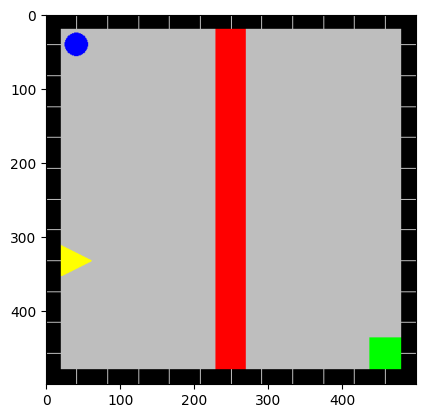

In [ ]:
mdp = StairwayToHeaven(gamma=0.99, horizon=100, action_success_prob=0.95, collapse_prob=0.03)
mdp.reset()
mdp.render()

# 1.2 Dynamic programming on Stairway to Heaven

1. Solve the stairway to heaven problem with Policy Iteration (PI) and Value Iteration (VI). Visualize the value function and the optimal policy for PI and VI. Compare the results. What do you observe?

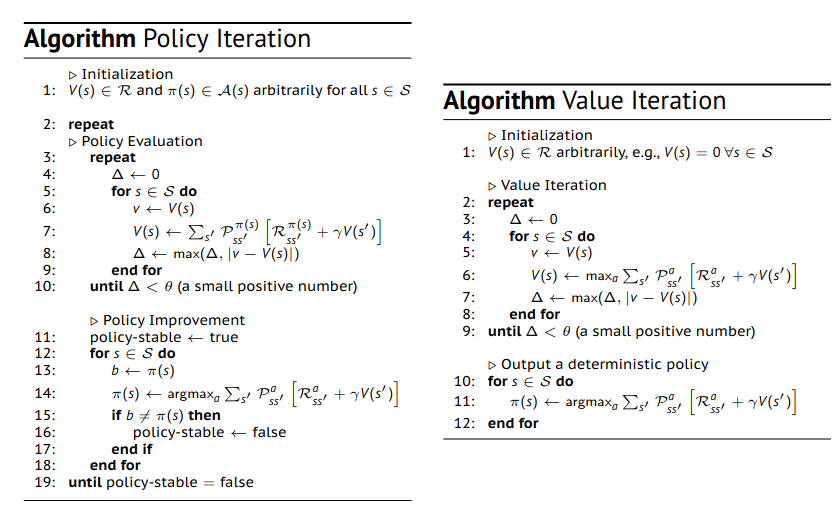

In [ ]:

from mushroom_rl.solvers.dynamic_programming import value_iteration, policy_iteration

def visualize_value_matrices(V_input, grid_map, cell_list, label):
  """
  This function visualizes the value matrices.
  Args:
      V_input: value matrix
      grid_map: np array containing the grid structure;
      cell_list: list of non-wall cells.
      label: label of plot

  """
  _, H, W = grid_map.shape
  # initialize value function
  V = np.ones((2, H, W)) * (-1)

  # iterate over all valid states
  for i, c in enumerate(cell_list):
    V[tuple(c)] = V_input[i]

  # create plot of value matrix
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  ax[0].set_title("Value matrix when the stairway is not built")
  ax[1].set_title("Value matrix when the stairway is built")
  ax[0].imshow(V[0], cmap='jet')
  ax[1].imshow(V[1], cmap='jet')
  # write the values in the cells
  for i in range(H):
      for j in range(W):
          if V[0,i,j]!=-1:
            ax[0].text(j, i, round(V[0, i, j], 2), ha="center", va="center", color="w")
          if V[1,i,j]!=-1:
            ax[1].text(j, i, round(V[1, i, j], 2), ha="center", va="center", color="w")
  # set title and show
  fig.suptitle(label)
  plt.show()

def visualize_policy(pi_input, directions, grid_map, cell_list, label):
    """
    This function visualizes the policy matrices.
    Args:
        pi: policy matrix
        directions: list of action changes
        grid_map: np array containing the grid structure;
        cell_list: list of non-wall cells.
        label: label of plot
    """
    _, H, W = grid_map.shape
    pi = np.ones((2, H, W), dtype=int) * (-1)

    # iterate over all valid states
    for i, c in enumerate(cell_list):
      pi[tuple(c)] = pi_input[i]

    # create plot of policy
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].set_title("Policy matrix when the stairway is not built")
    ax[1].set_title("Policy matrix when the stairway is built")
    ax[0].imshow(pi[0], cmap='jet')
    ax[1].imshow(pi[1], cmap='jet')
    # draw the policy arrows
    for i in range(H):
        for j in range(W):
          if pi[0,i,j]!=-1:
            ax[0].arrow(j, i, 0.25*directions[pi[0, i, j]][1], 0.25*directions[pi[0, i, j]][0], head_width=0.2, head_length=0.1, color='w')
          if pi[1,i,j]!=-1:
            ax[1].arrow(j, i, 0.25*directions[pi[1, i, j]][1], 0.25*directions[pi[1, i, j]][0], head_width=0.2, head_length=0.1, color='w')
    # set title and show
    fig.suptitle(label)
    plt.show()

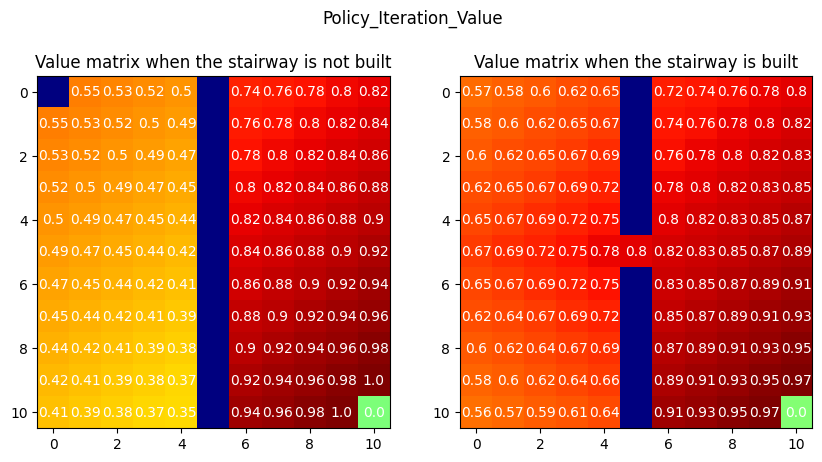

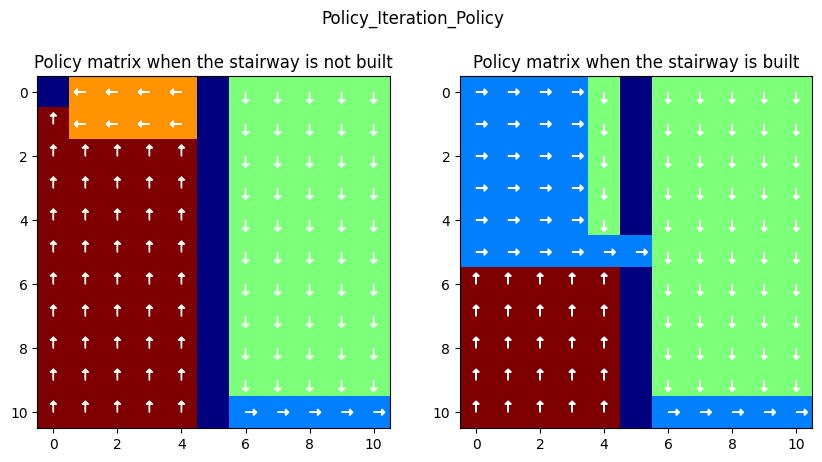

In [ ]:
p = mdp.p
r = mdp.r

# run policy iteration
V, pi = policy_iteration(p, r, gamma=0.99)

# visualize the policy matrices
visualize_value_matrices(V, mdp.grid_map, mdp.cell_list, "Policy_Iteration_Value")
visualize_policy(pi, mdp.directions, mdp.grid_map, mdp.cell_list, "Policy_Iteration_Policy")


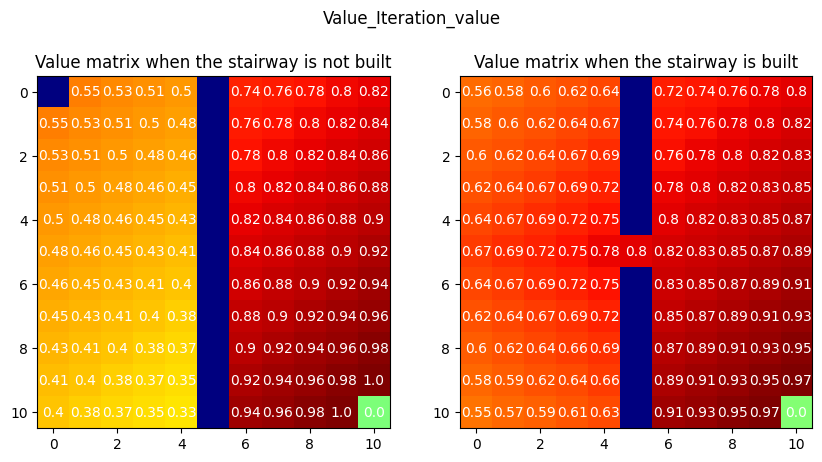

In [ ]:
# run value iteration
V = value_iteration(p, r, gamma=0.99, eps=0.01)

# visualize the value matrices
visualize_value_matrices(V, mdp.grid_map, mdp.cell_list, "Value_Iteration_value")

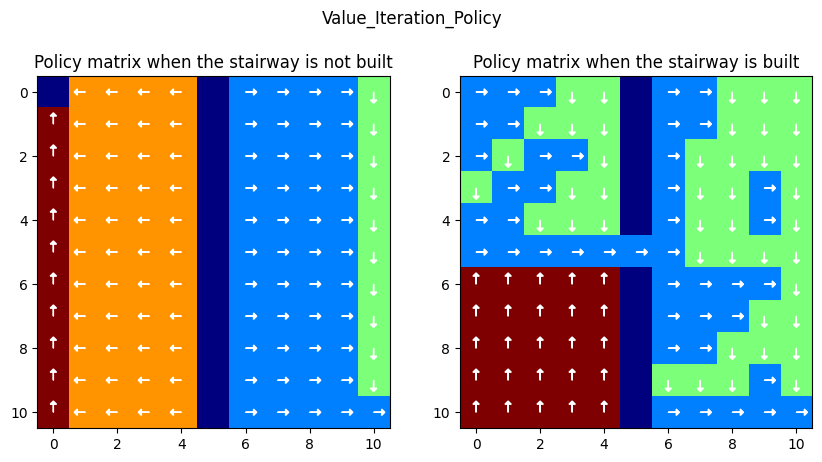

In [ ]:
# for Value iteration we need to extract the policy from the value function
def extract_policy(value, mdp, gamma=0.99):
    Rsa = np.einsum('ijk,ijk->ij', mdp.p, mdp.r)
    Pv = np.einsum('ijk,k->ij', mdp.p, value)
    # compute optimal Q
    Qsa = Rsa + gamma * Pv
    return np.argmax(Qsa, axis=1)

pi = extract_policy(V, mdp, gamma=0.99)
visualize_policy(pi, mdp.directions, mdp.grid_map, mdp.cell_list, "Value_Iteration_Policy")

2. Modify the Policy Iteration method in Mushroom so that it can accept a policy initialization and stopping criterion (in terms of number of iterations). Initialize with a policy that always goes RIGHT. Compare the obtained Value Function and Policy compared to your result in q.1.
What do you observe?

In [ ]:
def policy_iteration_modified(p, r, gamma, initial_policy=None, n_iterations=-1):
    """
    Args:
      prob (np.ndarray): transition probability matrix;
      reward (np.ndarray): reward matrix;
      gamma (float): discount factor.
      initial_policy (int or np.ndarray): value to intialize the policy.
        if np.ndarray is provided, use it as the initial policy.
      n_iterations (int): number of iterations to run the algorithm.
        if -1 is provided, the stopping criterion is the convergence.
    Returns:
      The optimal value of each state and the optimal policy.
    """
    # get the number of states and actions
    n_states = p.shape[0]
    n_actions = p.shape[1]

    # initialize the policy and value matrices
    if isinstance(initial_policy, np.ndarray):
        policy = initial_policy
    elif isinstance(initial_policy, int):
        policy = np.ndarray(n_states, dtype=int)
        policy.fill(initial_policy)
    else:
        policy = np.zeros(n_states, dtype=int)
    value = np.zeros(n_states)

    if n_iterations == -1:
        n_iterations = np.inf

    # iterate until the policy and value stop changing
    it_count = 0
    changed = True
    while changed and it_count < n_iterations:
        it_count += 1

        ####################
        # Policy Evaluation
        ####################
        i = np.eye(n_states)
        # array to collect P^{pi} and R^{pi} over next states
        p_pi = np.zeros((n_states, n_states))   # probabilities of transitions
        r_pi = np.zeros(n_states)               # reward for each transition
        # iterate over next states and fill in r_pi and p_pi
        for state in range(n_states):
            action = policy[state]
            # Get P_s^{pi} and R_s^{pi}
            p_s_pi = p[state, action, :]
            r_s_pi = r[state, action, :]
            # update P^{pi} with P_s^{pi}
            p_pi[state, :] = p_s_pi.T
            # update R^{pi} with P_s^{pi}^T . R_s^{pi}
            r_pi[state] = p_s_pi.T.dot(r_s_pi)
        # solve to get V : V (I-\gamma P^{pi}) = R^{pi}
        value = np.linalg.solve(i - gamma * p_pi, r_pi)

        ####################
        # Policy iteration
        ####################
        changed = False
        # iterate over the states and update the policy if the new value of the state is bigger
        for state in range(n_states):
            vmax = value[state]
            # check for all actions, if different action better
            for action in range(n_actions):
                # check different action from policy
                if action != policy[state]:
                    # get probability and reward for s,a pair
                    p_sa = p[state, action]
                    r_sa = r[state, action]
                    # compute value with matrix form of policy iteration
                    val = p_sa.T.dot(r_sa + gamma * value)
                    # check if better
                    if val > vmax and not np.isclose(val, vmax):
                        policy[state] = action # improve
                        vmax = val
                        changed = True  # policy not stable yet
    return value, policy

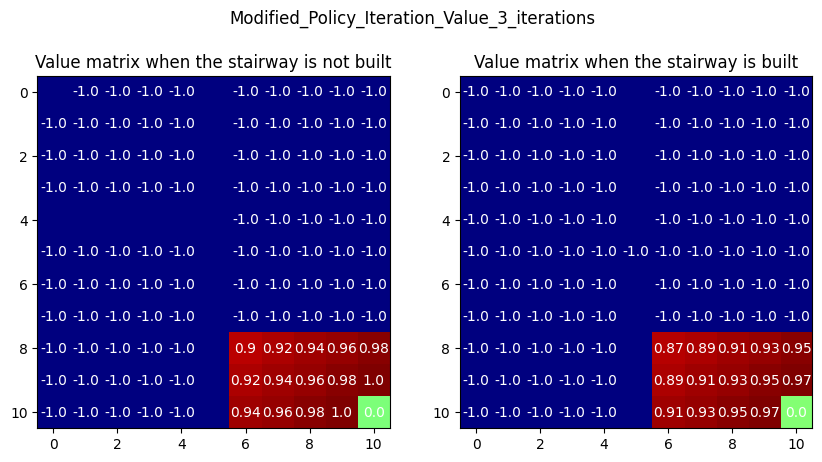

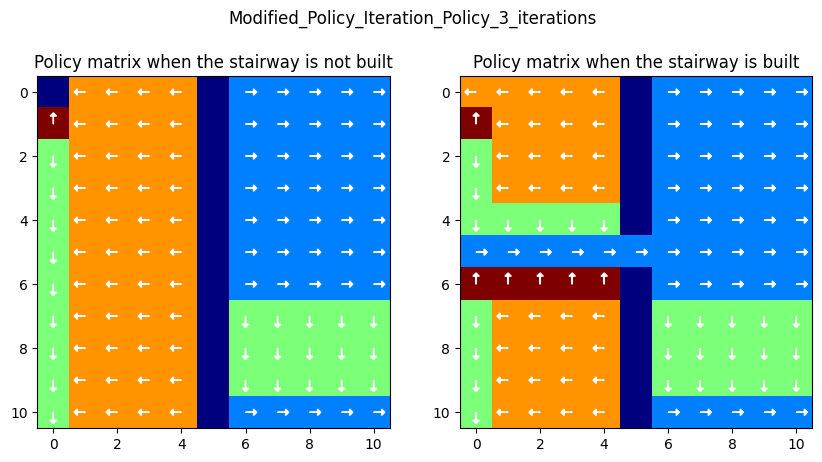

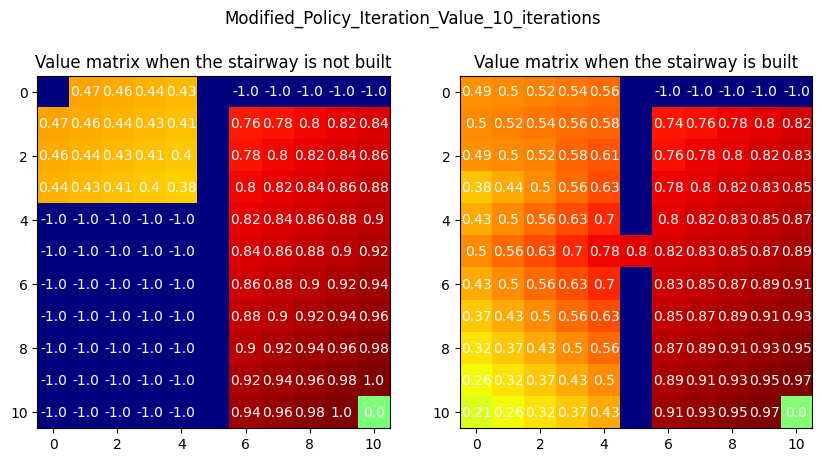

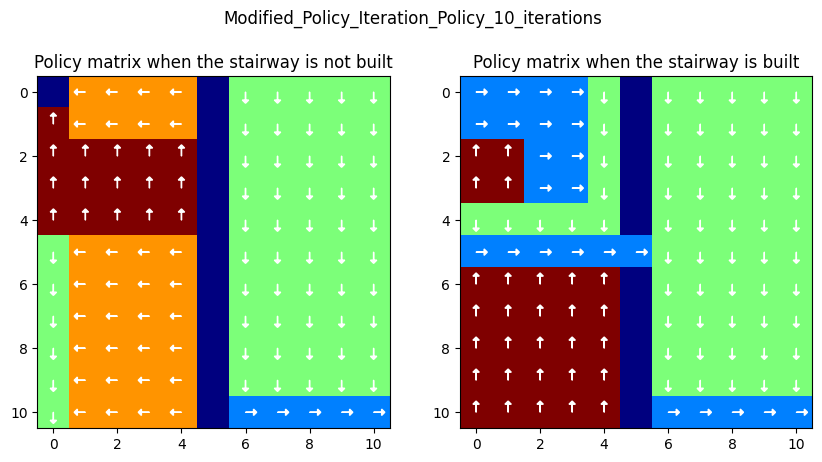

In [ ]:
# init policy with action RIGHT (0)
# run policy iteration for 3 iterations
V, pi = policy_iteration_modified(p, r, gamma=0.99, initial_policy=0, n_iterations=3)
# visualize the policy matrices
visualize_value_matrices(V, mdp.grid_map, mdp.cell_list, "Modified_Policy_Iteration_Value_3_iterations")
visualize_policy(pi, mdp.directions, mdp.grid_map, mdp.cell_list, "Modified_Policy_Iteration_Policy_3_iterations")

# run policy iteration for 10 iterations
V, pi = policy_iteration_modified(p, r, gamma=0.99, initial_policy=0, n_iterations=10)
# visualize the policy matrices
visualize_value_matrices(V, mdp.grid_map, mdp.cell_list, "Modified_Policy_Iteration_Value_10_iterations")
visualize_policy(pi, mdp.directions, mdp.grid_map, mdp.cell_list, "Modified_Policy_Iteration_Policy_10_iterations")

3. Implement the exact policy evaluation using the matrix-based formulation of the Bellman equation.

In [ ]:
def exact_policy_evaluation(policy, prob, reward, gamma):
  """
  Args:
    policy (np.ndarray or a MushroomRL policy): the policy to evaluation
    prob (np.ndarray): transition probability matrix;
    reward (np.ndarray): reward matrix;
    gamma (float): discount factor.

  Returns:
      The optimal value of each state.
  """
  # get the number of states and actions
  n_states = prob.shape[0]
  n_actions = prob.shape[1]

  ####################
  # Policy Evaluation
  ####################
  # I
  i = np.eye(n_states)
  # array to collect P^{pi} and R^{pi} over next states
  p_pi = np.zeros((n_states, n_states))
  r_pi = np.zeros(n_states)
  # iterate over next states
  for state in range(n_states):
    # get the action form the policy
    action = policy[state]
    # get P_s^{pi} and R_s^{pi}
    p_pi_s = prob[state, action, :]
    r_pi_s = reward[state, action, :]
    # update P^{pi} with P_s^{pi}
    p_pi[state, :] = p_pi_s.T
    # update R^{pi} with P_s^{pi}^T . R_s^{pi}
    r_pi[state] = p_pi_s.T.dot(r_pi_s)
  # solve to get V : V (I-\gamma P^{pi}) = R^{pi}
  value = np.linalg.solve(i - gamma * p_pi, r_pi)

  return value

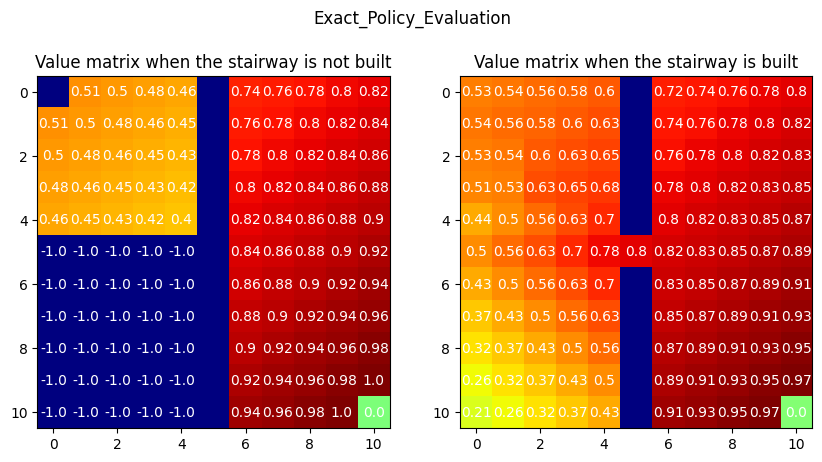

In [ ]:
V_exact = exact_policy_evaluation(pi, p, r, gamma=0.99)
# visualize the value matrices
visualize_value_matrices(V_exact, mdp.grid_map, mdp.cell_list, "Exact_Policy_Evaluation")

# 1.3 Model-free RL on Stairway to Heaven

1. Take the policy of iteration 10 from policy iteration and do the n-step TD policy evaluation and Monte Carlo.

**N-step TD Policy Evaluation** (RL book - page 166)

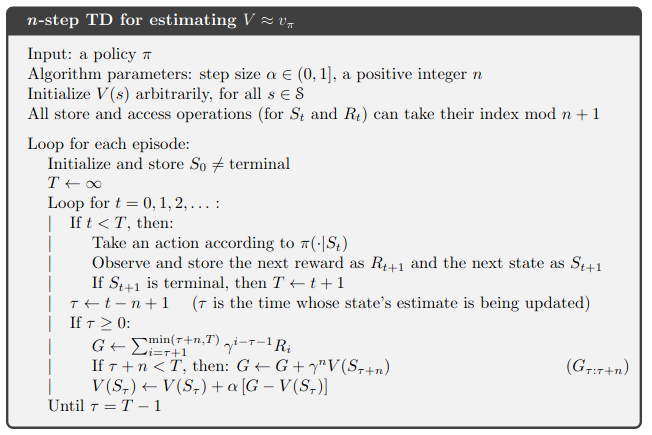

In [ ]:
from tqdm import trange

def TD_policy_eval(n, policy, mdp, num_rollout=100, alpha=0.1, gamma=0.99):
    """
    This function runs n-step TD policy evaluation
    Args:
      n (int): n step lookahead of TD target;
      policy (np.ndarray or a MushroomRL policy): the policy to evaluate;
      mdp: class instance of the mdp;
      num_rollout (int): number of rollouts to perform;
      alpha (float): step size;
      gamma (float): discount factor.

    Returns:
        The estimated value of each state.
    """
    # n-step TD for estimating the value
    # RL book - page 166
    n_states = mdp.p.shape[0]
    V = np.zeros(n_states)

    # perform multiple rollouts of policy
    for _ in trange(num_rollout):
        state = mdp.reset()
        T = 1000
        t = 0
        tau = 0
        # initialize lists to store states and rewards of rollout
        states = [state]
        rewards = [0]

        while tau < T-1:
            if t < T:
                # take an action according to the policy
                if isinstance(policy, np.ndarray):
                    a = policy[state]
                else:
                    a = policy.draw_action(state)
                state, reward, done, _ = mdp.step(a)
                # store the next state and reward
                states.append(state)
                rewards.append(reward)
                if done:
                    T = t + 1  # set end time of rollout
            # tau is the time whose state's estimate is being updated (need to observe next n states first)
            tau = t - n + 1
            if tau >= 0:
                # calculate n-step return
                G = 0
                for i in range(tau+1 , min(tau+n+1, T+1)):
                    G += (gamma**(i-tau-1)) * rewards[i]
                if tau + n < T:
                    G += (gamma**n) * V[states[tau+n]]
                # update value function using the n-step TD learning formula
                V[states[tau]] += alpha * (G - V[states[tau]])
            t += 1
    return V

100%|██████████| 100/100 [00:03<00:00, 32.90it/s]


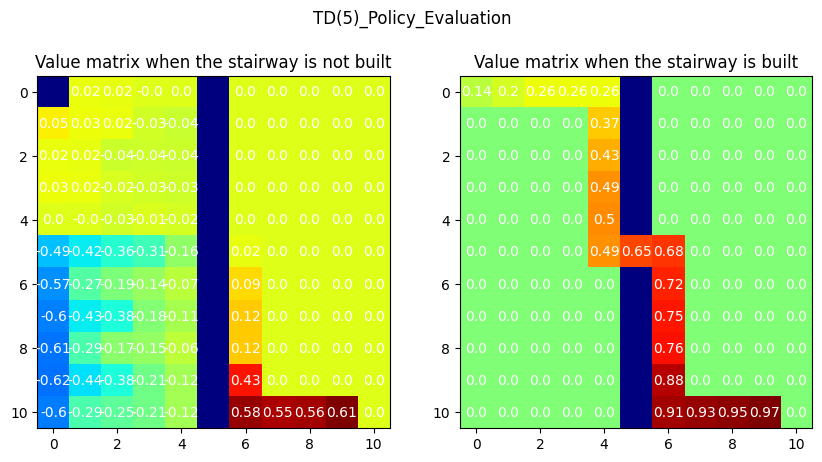

In [ ]:
V_TD = TD_policy_eval(5, pi, mdp)
visualize_value_matrices(V_TD, mdp.grid_map, mdp.cell_list, "TD(5)_Policy_Evaluation")

**First-visit MC policy evaluation** (RL book - page 114)

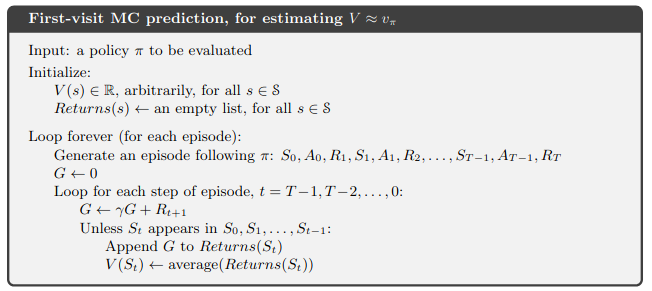

In [ ]:
from mushroom_rl.core.core import defaultdict
def rollout(policy, mdp):
    '''Assuming policy is an ndarray one or two dims'''
    state = mdp.reset()
    done = False
    states, actions, rewards = [], [], []
    t = 0
    # perform one rollout
    while not done and t < mdp.info.horizon:
        # draw action
        if isinstance(policy, np.ndarray):
          a = policy[state]
        else:
          a=policy.draw_action(state)
        states.append(state[0])
        actions.append(a)
        # execute action
        state, r, done, _ = mdp.step(a)
        rewards.append(r)
        t += 1
    return states, actions, rewards

def MC_policy_eval(policy, mdp, num_rollout=100, gamma=0.99):
    """
    First-visit MC prediction to estimate value
    Args:
      policy (np.ndarray or a MushroomRL policy): the policy to evaluate;
      mdp: class instance of the mdp;
      num_rollout (int): number of rollouts to perform;
      gamma (float): discount factor.

    Returns:
        The estimated value of each state.
    """
    # RL book - page 114
    n_states = mdp.p.shape[0]
    V = np.zeros(n_states)
    returns = defaultdict(list)

    # perform multiple rollouts of the policy
    for _ in trange(num_rollout):
        states, actions, rewards = rollout(policy, mdp)
        G = 0
        T = len(states)
        # loop backwards through rollout
        for t in range(T-1,-1,-1):
            # calculate return
            G = gamma * G + rewards[t] # last reward is R_T, while last state is S_{t-1}

            # only consider return of first visit of each state
            if states[t] not in states[:t]:
                # average return
                returns[states[t]].append(G)
                V[states[t]] = np.mean(returns[states[t]])
    return V

100%|██████████| 100/100 [00:00<00:00, 300.03it/s]


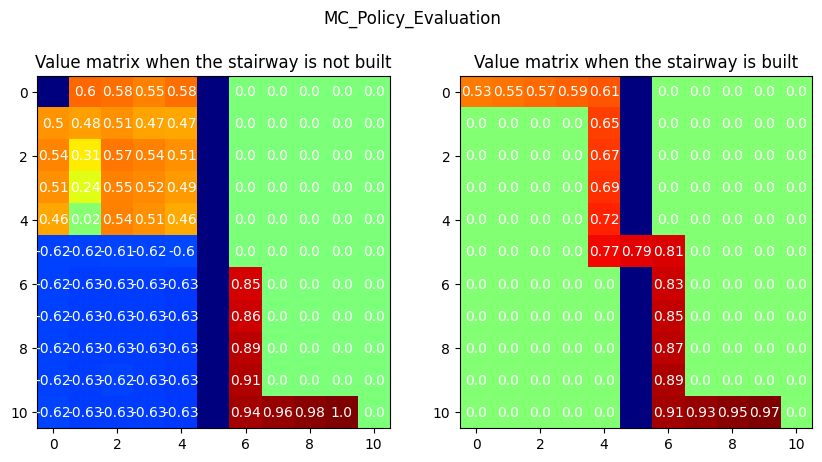

In [ ]:
V_MC = MC_policy_eval(pi, mdp)
visualize_value_matrices(V_MC, mdp.grid_map, mdp.cell_list, "MC_Policy_Evaluation")

2. Train the same MDP with Q-Learning, SARSA and SARSA(λ) with an ε-Greedy policy. Run 5 random seeds and plot the evaluation curves for all algorithms when you evaluate the policy every n step. Plot the evaluation curves average returns J w.r.t. epochs.

In [ ]:
from mushroom_rl.algorithms.value import SARSA, QLearning, SARSALambda
from mushroom_rl.core import Core, Logger
from mushroom_rl.policy import EpsGreedy
from mushroom_rl.utils.parameters import ExponentialParameter, Parameter
from mushroom_rl.utils.callbacks import CollectDataset, CollectMaxQ
from mushroom_rl.utils.dataset import compute_J, parse_dataset

from tqdm import trange
import scipy.stats as st
import matplotlib.pyplot as plt

class Exp:
    """
    A class to launch experiments with Weights & Biases logging
    """
    def __init__(self, mdp, config_general, exp_configs):
        # general config for all experiments
        self.config_general = config_general
        # initialize the MDP environment
        # eval() function in python is used to evaluate the string as a python expression
        #        we can pass the string of the class name and it will be evaluated as a class
        # **config_general['mdp_params'] is a dictionary unpacking
        #        the dictionary will be unpacked and passed as keyword arguments to the class
        self.mdp = mdp
        # the project is the name of the project for wandb
        self.project = config_general['project_name']
        # save the experiment configs
        self.exp_configs = exp_configs
        # number fo runs for each experiment
        self.n_runs = config_general['n_runs']
        self.n_epochs = config_general['n_epochs']
        # collect data for visualization
        self.data = {}

    def run_experiments(self):
        # fig = plt.figure()
        plt.suptitle(self.config_general['project_name'])
        legend_labels = []

        # iterate over the experiment configs and run the experiments
        for config in exp_configs:
            # we group the runs for the same agent by the group name
            # this allows us to compare the runs in the wandb dashboard
            self.group_name = config['group_name']

            # we load the config for the experiment
            self.config = config

            # Run the experiments
            Js = []
            for i in range(self.n_runs):
              J = self.run_seed(i)
              Js.append(J)

            # save the results to a file using numpy
            np.save(self.group_name, Js)
            # save the data for visualization
            self.data[self.group_name] = np.array(Js)

        # visualize the results
        self.visualize_results()

    def run_seed(self, i):
        # set the seed
        np.random.seed()

        # initialize the policy and the agent
        policy = eval(self.config['policy'])(**self.config['policy_params'])
        agent = eval(self.config['agent'])(self.mdp.info, policy, **self.config['agent_params'])
        run_name = self.group_name + '_' + str(i)

        # set the algorithm
        core = Core(agent, self.mdp)

        # learn over multiple epochs
        Js = np.zeros(self.n_epochs)
        for i in trange(self.n_epochs, desc = run_name):
          # run the algorithm
          core.learn(**self.config['learn_params'], quiet=True)
          # evaluate the agent
          dataset = core.evaluate(**self.config['eval_params'], quiet=True)
          # get J value
          J = np.mean(compute_J(dataset, mdp.info.gamma))
          Js[i] = J
        # save the agent
        agent.save('agent_' + run_name + '.msh')
        return Js

    def visualize_results(self):
        plt.figure(figsize=(10, 7))

        # iterate over data
        for k in self.data.keys():
          Js = self.data[k]
          # compute the mean and the 95% confidence interval of the results
          mean_Js = np.mean(Js, axis=0)
          lower_bound, upper_bound = st.t.interval(0.95, len(Js)-1, loc=mean_Js, scale=st.sem(Js))
          # plot the results
          plt.plot(mean_Js, label=k)
          plt.fill_between(np.arange(len(mean_Js)), lower_bound, upper_bound, alpha=0.3)

        plt.xlabel('epochs')
        plt.ylabel('J')
        plt.legend()
        # save the plot
        plt.savefig(self.project + '.png')
        plt.show()

# define the experiment
config_general = {
    'project_name': 'HW1',
    'n_runs': 5,
    'n_epochs':100,
    'mdp': 'StairwayToHeaven',
    'mdp_params':{'gamma':0.99, 'horizon':100, 'action_success_prob': 0.95, 'collapse_prob':0.03},
}
exp_configs = [
    {
        'group_name': 'QLearning',
        'agent': 'QLearning',
        'agent_params': {'learning_rate':Parameter(0.01)},
        'policy': 'EpsGreedy',
        'policy_params': {'epsilon':ExponentialParameter(value=0.1, exp=1)},
        'learn_params': {'n_episodes': 100, 'n_steps_per_fit': 1},
        'eval_params': {'n_episodes': 5}
    },
    {
        'group_name': 'SARSA',
        'agent': 'SARSA',
        'agent_params': {'learning_rate':Parameter(0.01)},
        'policy': 'EpsGreedy',
        'policy_params': {'epsilon':ExponentialParameter(value=0.1, exp=1)},
        'learn_params': {'n_episodes': 100, 'n_steps_per_fit': 1},
        'eval_params': {'n_episodes': 5}
    },
    {
        'group_name': 'SARSALambda',
        'agent': 'SARSALambda',
        'agent_params': {'learning_rate':Parameter(0.01), 'lambda_coeff':Parameter(0.75)},
        'policy': 'EpsGreedy',
        'policy_params': {'epsilon':ExponentialParameter(value=0.1, exp=1)},
        'learn_params': {'n_episodes': 100, 'n_steps_per_fit': 1},
        'eval_params': {'n_episodes': 5}
    }
]

In [ ]:
# launch the experiment
mdp = eval(config_general['mdp'])(**config_general['mdp_params'])
launcher = Exp(mdp, config_general, exp_configs)

SARSALambda_4: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2304: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


<Figure size 640x480 with 0 Axes>

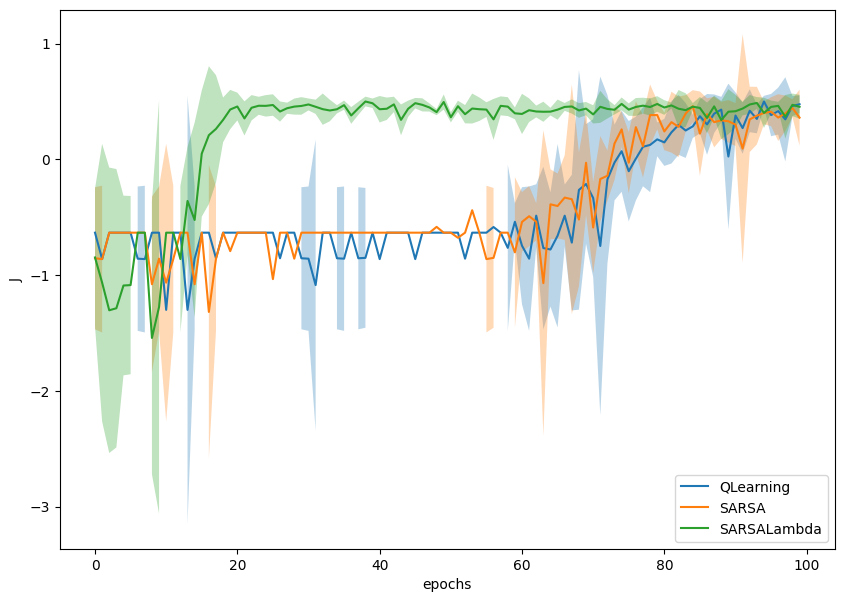

In [ ]:
launcher.run_experiments()

3. plot value function and the policy that the algorithm converges to. explain the differences.

In [ ]:
def visualize_policy(Q, directions, grid_map, cell_list, label):
    """
    This function visualizes the policy matrices from an action_value matrix.
    Args:
        Q: action_value matrix
        directions: list of action changes
        grid_map: np array containing the grid structure;
        cell_list: list of non-wall cells.
        label: label of plot
    """
    _, H, W = grid_map.shape
    pi = np.ones((2,H,W), dtype=int) * (-1)

    # iterate over all valid states
    for i, c in enumerate(cell_list):
      pi[tuple(c)] = np.argmax(Q[i])

    # create plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].set_title("Policy matrix " + label)
    ax[0].imshow(pi[0], cmap='jet')
    ax[1].set_title("Policy matrix " + label)
    ax[1].imshow(pi[1], cmap='jet')
    # draw the policy arrows
    for i in range(H):
        for j in range(W):
          if pi[0,i,j]!=-1:
            ax[0].arrow(j, i, 0.25*directions[pi[0,i, j]][1], 0.25*directions[pi[0,i, j]][0], head_width=0.2, head_length=0.1, color='w')
          if pi[1,i,j]!=-1:
            ax[1].arrow(j, i, 0.25*directions[pi[1,i, j]][1], 0.25*directions[pi[1,i, j]][0], head_width=0.2, head_length=0.1, color='w')
    plt.show()

In [ ]:
def load_and_visualize(agent_name):
      # get the group name from the agent name
      group_name = agent_name.split('_')[1]
      # get the config for the agent
      config = [config for config in exp_configs if config['group_name'] == group_name][0]
      # initialize the policy and the agent
      policy = eval(config['policy'])(**config['policy_params'])
      agent = eval(config['agent'])(mdp.info, policy, **config['agent_params'])
      # load the agent
      agent = agent.load(agent_name)

      # visualize the policy with TD and MC
      V_TD = TD_policy_eval(5, agent.policy, mdp)
      visualize_value_matrices(V_TD, mdp.grid_map, mdp.cell_list, group_name + ' TD(5)')

      V_MC = MC_policy_eval(agent.policy, mdp)
      visualize_value_matrices(V_MC, mdp.grid_map, mdp.cell_list, group_name + ' MC')

100%|██████████| 100/100 [00:00<00:00, 247.43it/s]


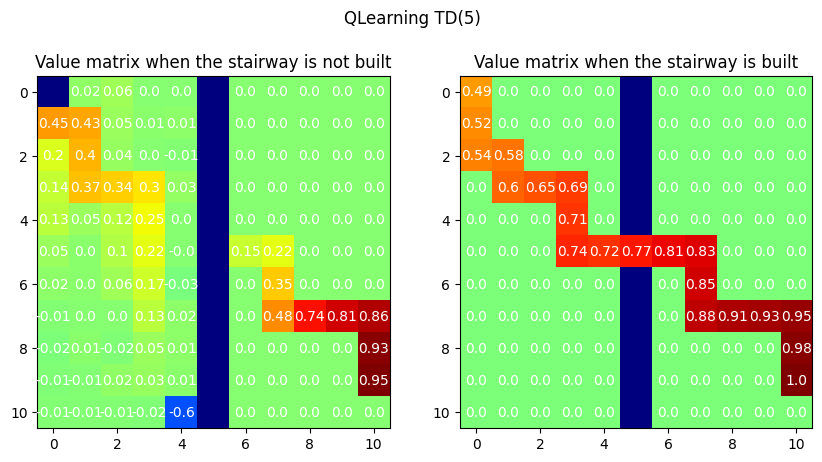

100%|██████████| 100/100 [00:00<00:00, 333.03it/s]


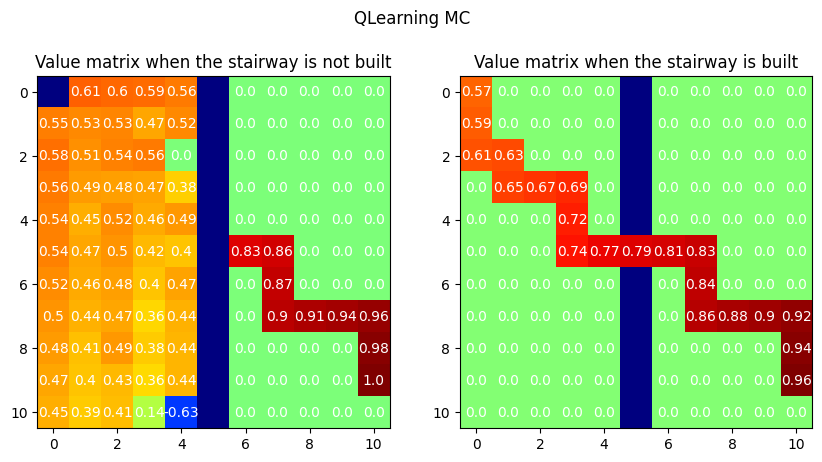

100%|██████████| 100/100 [00:00<00:00, 153.41it/s]


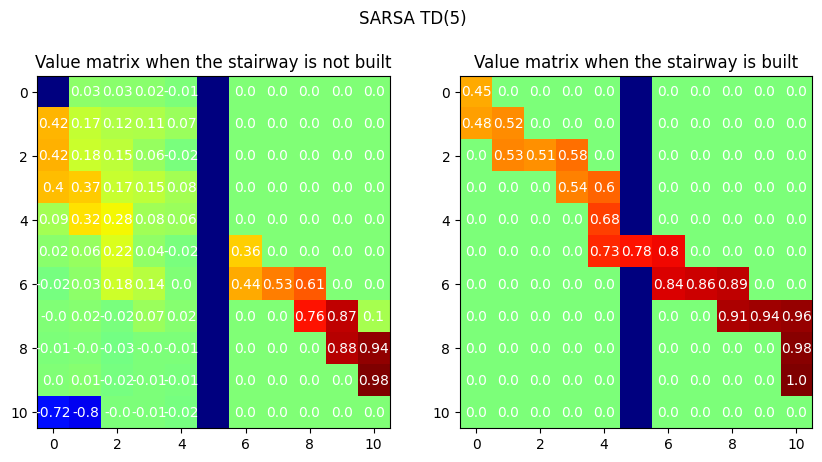

100%|██████████| 100/100 [00:00<00:00, 335.57it/s]


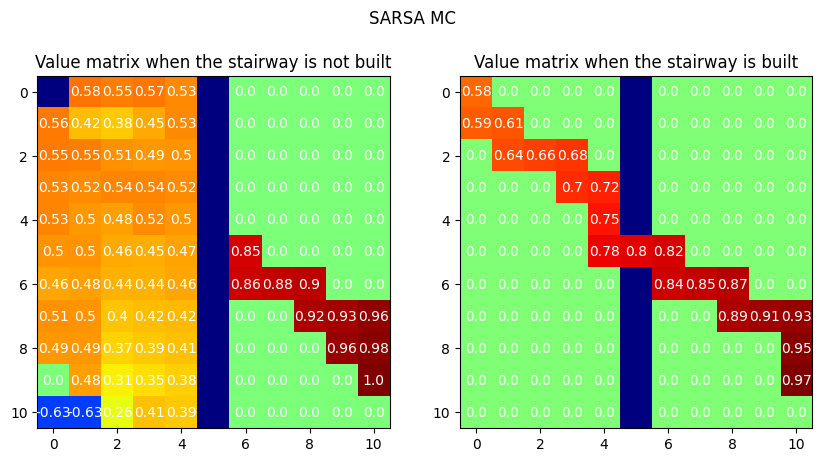

100%|██████████| 100/100 [00:00<00:00, 333.29it/s]


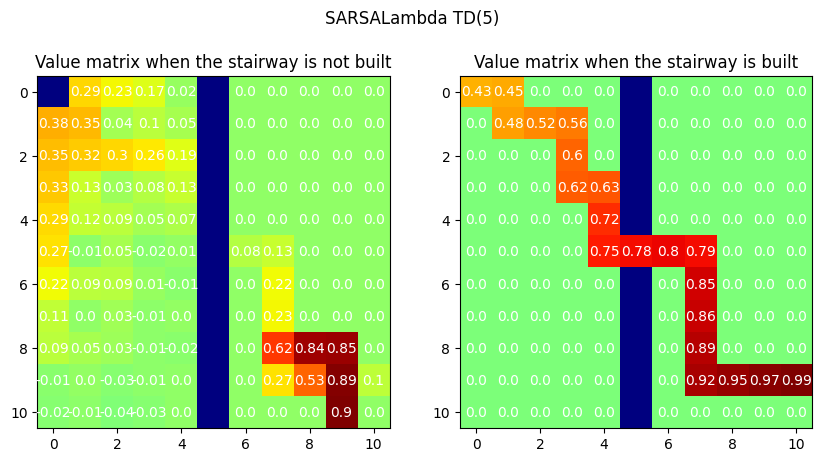

100%|██████████| 100/100 [00:00<00:00, 360.09it/s]


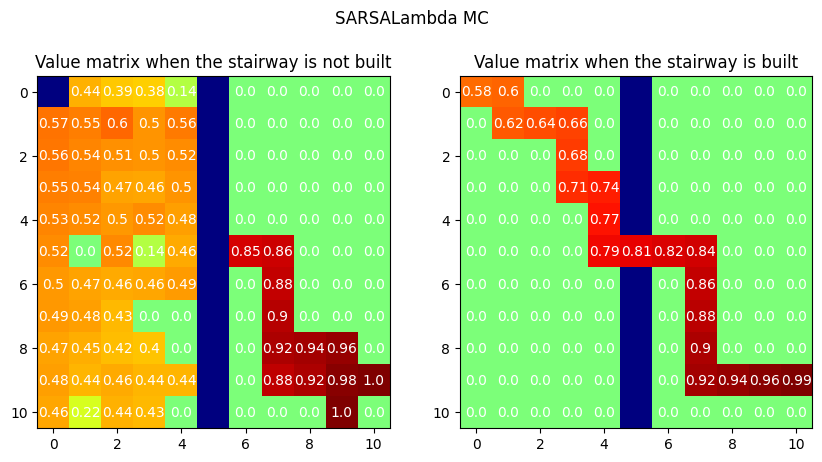

In [ ]:
for config in exp_configs:
  # visualize the first seed only
  load_and_visualize('agent_' + config['agent'] + '_0.msh')